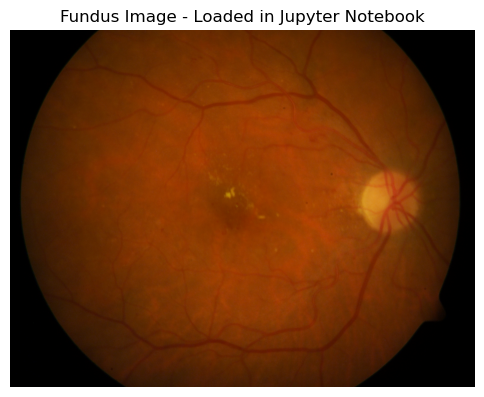

In [3]:
from PIL import Image
import matplotlib.pyplot as plt

# Load the fundus images 
image = Image.open('ddb1_v02_01/images/diaretdb1_image001.png')

# Display the image
plt.figure(figsize=(6,6))
plt.imshow(image)
plt.axis('off') 
plt.title("Fundus Image - Loaded in Jupyter Notebook")
plt.show()